In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t, norm, binom, rankdata
from sklearn.linear_model import LinearRegression

# Enter 2 columns of B (before), A (after)
dt = {'R': [113,105,130,101,138,118,87,116,75,96,122,103,116,107,118,103,111,104, 111,89,78,100,89,85,88], 
      'L': [137,105,133,108,115,170,103,145,78,107,84,148,147,87,166,146,123,135,112,93,76,116,78,101,123]}

df = pd.DataFrame(dt)
df.drop(index=df[df.R==df.L].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df['Diff'] = df.apply(lambda X: X['R'] - X['L'], axis=1)
df['Sign'] = df['Diff'].apply(lambda d: 1 if d > 0 else -1 if d < 0 else 0)
df['Rank'] = rankdata(df.Diff * df.Sign) * df.Sign
df

,R,L,Diff,Sign,Rank
0,113,137,-24,-1,-15.0
1,130,133,-3,-1,-3.5
2,101,108,-7,-1,-6.0
3,138,115,23,1,14.0
4,118,170,-52,-1,-24.0
5,87,103,-16,-1,-11.0
6,116,145,-29,-1,-16.0
7,75,78,-3,-1,-3.5
8,96,107,-11,-1,-7.5
9,122,84,38,1,20.0


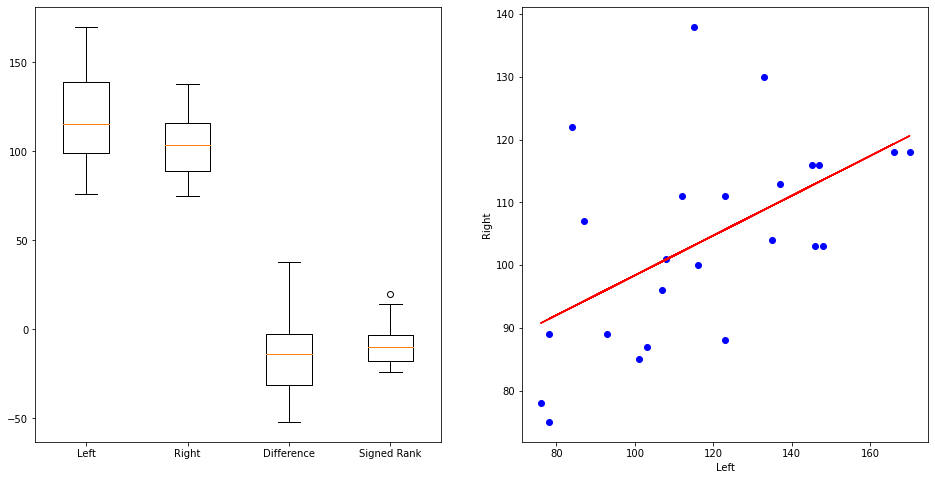

In [2]:
w, h = 2, 1
fig, axes = plt.subplots(h, w, figsize=(16, 8))

axes[0].boxplot([df.L, df.R, df.Diff, df.Rank], 
                labels=['Left', 'Right', 'Difference', 'Signed Rank'])
axes[1].scatter(df.L, df.R, color='b')
axes[1].set_xlabel('Left')
axes[1].set_ylabel('Right')

model = LinearRegression()
model.fit(df['L'].values.reshape(-1,1), df['R'].values.reshape(-1,1))
Y = model.predict(df.L.values.reshape(-1,1))
axes[1].plot(df.L, Y, color='r')

plt.show()

#### 1. Difference Test

In [3]:
# The mean of Diff is normally distributed, hence
mean = df['Diff'].mean()
std_mean = df['Diff'].std() / (len(df))**0.5
round(mean, 3), round(std_mean, 3)

(-13.875, 4.747)

In [4]:
# Set significant level alpha, degree of freedoms, one tail or two tails.
alpha, ddof = 0.05, len(df) - 1
two_tails = True

# Compute the t statistic value
if two_tails:
    t_alpha = t.ppf(1 - alpha/2, ddof) 
else:
    t_alpha = t.ppf(1 - alpha, ddof) 

round(t_alpha, 3)

2.069

In [5]:
# Compute the (1 - alpha) * 100% confidence interval
ci = (mean - t_alpha * std_mean, mean + t_alpha * std_mean)
round(ci[0], 3), round(ci[1], 3)

(-23.696, -4.054)

In [6]:
# Asumme H0 is true, then Diff = 0, hence the t statistic:
t_null = abs(mean) / std_mean
round(t_null, 3)

2.923

In [7]:
# Evaluate the rejection of H0
if t_null > t_alpha:
    print('The test statistic is statistically significant. H0 should be rejected!')
else:
    print('The test statistic is not statistically significant. H0 cannot be rejected!')

The test statistic is statistically significant. H0 should be rejected!


In [8]:
p_value = 1 - t.cdf(t_null, ddof)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.008


In [9]:
# Other way to compute the p_value using the survival function of stats
p_value = t.sf(t_null, ddof)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.008


#### 2. Signed Rank

In [10]:
n = len(df)
# Compute the mean and the std of the rank
mean = n * (n + 1) / 4
std_ = (n * (n + 1) * (2 * n + 1) / 24)**0.5
round(mean, 3), round(std_, 3)

(150.0, 35.0)

In [11]:
# Set significant level alpha, one tail or two tails.
alpha = 0.05
two_tails = True

# Compute the Z statistic value
if two_tails:
    Z_alpha = norm.ppf(1 - alpha/2) 
else:
    Z_alpha = norm.ppf(1 - alpha) 

round(Z_alpha, 3)

1.96

In [12]:
# Compute confidence interval according to the significant level alpha
ci = (mean - Z_alpha * std_, mean + Z_alpha * std_)
round(ci[0], 3), round(ci[1], 3)

(81.401, 218.599)

In [13]:
# Asumme H0 is true, then Rank = 0, hence the Z statistic:
positive_sum = df['Rank'][df.Rank > 0].sum()
Z_null = abs(positive_sum - mean) / std_
positive_sum, round(Z_null, 3)

(56.5, 2.671)

In [14]:
# Evaluate the rejection of H0
if Z_null > Z_alpha:
    print('The test statistic is statistically significant. H0 should be rejected!')
else:
    print('The test statistic is not statistically significant. H0 cannot be rejected!')

The test statistic is statistically significant. H0 should be rejected!


In [15]:
p_value = 1 - norm.cdf(abs(Z_null))

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.008


In [16]:
# Other way to compute the p_value using the survival function of stats
p_value = norm.sf(abs(Z_null))

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.008


#### 3. Sign Test

In [17]:
len(df[df.Sign > 0]), len(df[df.Sign < 0]), n

(5, 19, 24)

In [18]:
# Compute the test statistic = min (# positive, # negative)
n, p = len(df), 0.5
k = min(len(df[df.Sign > 0]), len(df[df.Sign < 0]))
k, n, p

(5, 24, 0.5)

In [19]:
# Compute the p-value = P(x <= k)
p_value = binom.cdf(k, n, p)
if two_tails:
    p_value *= 2
round(p_value, 3)

0.007

In [20]:
alpha = 0.05

# Evaluate the rejection of H0
if p_value < alpha:
    print('The test statistic is statistically significant. H0 should be rejected!')
else:
    print('The test statistic is not statistically significant. H0 cannot be rejected!')

The test statistic is statistically significant. H0 should be rejected!
